## Import Libraries

In [1]:
!pip install xlrd geopy


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [11]:
# !pip install python-dotenv
import requests
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from dotenv import load_dotenv
import os
os.environ['OGR_GEOMETRY_ACCEPT_UNCLOSED_RING'] = 'NO'
import zipfile
import shutil
import numpy as np
import pandas as pd
import folium
import branca.colormap as cm
from shapely.geometry import Point, LineString

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
# Retrieving api key
load_dotenv("../key.env")
api_key = os.getenv("API_KEY")

## Import Datasets

In [12]:
%run get_bus_info_function.ipynb
bus_services_df = get_bus_info("https://datamall2.mytransport.sg/ltaodataservice/BusServices", api_key)
bus_routes_df = get_bus_info("https://datamall2.mytransport.sg/ltaodataservice/BusRoutes", api_key)
bus_stops_df = get_bus_info("https://datamall2.mytransport.sg/ltaodataservice/BusStops", api_key)
train_stations = pd.read_excel("../datasets/Train_Stations.xls")

ConnectionError: HTTPSConnectionPool(host='datamall2.mytransport.sg', port=443): Max retries exceeded with url: /ltaodataservice/BusRoutes?$skip=3500 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000001AF227025E0>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed'))

In [ ]:
%run get_geospatial_function.ipynb
geospatial_train_path = "../datasets/geospatial_layer/TrainStation_Jul2024/RapidTransitSystemStation.shp"
geospatial_train_gdf = gpd.read_file(geospatial_train_path)
geospatial_train_gdf['geometry'] = geospatial_train_gdf['geometry'].buffer(0)

## Data Preprocessing

In [13]:
# Filter for Trunk Services
trunk_buses_df = bus_services_df[bus_services_df['Category'] == "TRUNK"]
trunk_buses_df = trunk_buses_df['ServiceNo']
trunk_bus_routes_df = pd.merge(trunk_buses_df, bus_routes_df,
                               on='ServiceNo', how='inner')
trunk_bus_routes_df = trunk_bus_routes_df[['ServiceNo', 'Direction', 'StopSequence', 'BusStopCode']]
geospatial_bus_route = pd.merge(trunk_bus_routes_df, bus_stops_df,
                                on='BusStopCode', how='inner')
geospatial_bus_route = geospatial_bus_route[['ServiceNo', 'Direction', 'StopSequence', 'BusStopCode', 'Latitude', 'Longitude']]
geospatial_bus_route.head()

,ServiceNo,Direction,StopSequence,BusStopCode,Latitude,Longitude
0,118,1,1,65009,1.403706,103.902243
1,118,1,2,65259,1.405352,103.901872
2,118,1,3,65409,1.406245,103.899575
3,118,1,4,65141,1.404548,103.897164
4,118,1,5,65431,1.402389,103.896736


## Bus Lines

In [14]:
# Ensure bus stops have the same CRS
geospatial_bus_route_gdf = gpd.GeoDataFrame(
    geospatial_bus_route,
    geometry=gpd.points_from_xy(geospatial_bus_route.Longitude, geospatial_bus_route.Latitude),
    crs="EPSG:4326"
)

# Sort and concatenate points for each ServiceNo without splitting by direction
def create_line(group):
    # Sort points by StopSequence and concatenate them
    sorted_group = group.sort_values(['Direction', 'StopSequence'])
    return LineString(sorted_group.geometry.tolist())

# Group by ServiceNo alone and apply the create_line function
bus_routes_lines = geospatial_bus_route_gdf.groupby('ServiceNo').apply(create_line).reset_index()
bus_routes_lines.columns = ['ServiceNo', 'geometry']

# Convert to a GeoDataFrame
bus_routes_lines_gdf = gpd.GeoDataFrame(bus_routes_lines, geometry='geometry', crs="EPSG:4326")

# Check your final bus_routes_lines_gdf
print(bus_routes_lines_gdf.head())


  ServiceNo                                           geometry
0        10  LINESTRING (103.94339 1.35408, 103.94339 1.354...
1       100  LINESTRING (103.87169 1.35047, 103.87169 1.350...
2      100A  LINESTRING (103.87169 1.35047, 103.87205 1.346...
3       101  LINESTRING (103.87169 1.35047, 103.87277 1.348...
4       102  LINESTRING (103.89267 1.37061, 103.89536 1.370...


C:\Users\aiko\AppData\Local\Temp\ipykernel_32532\1849526958.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  bus_routes_lines = geospatial_bus_route_gdf.groupby('ServiceNo').apply(create_line).reset_index()


0    LINESTRING (103.94339 1.35408, 103.94339 1.354...
Name: geometry, dtype: geometry


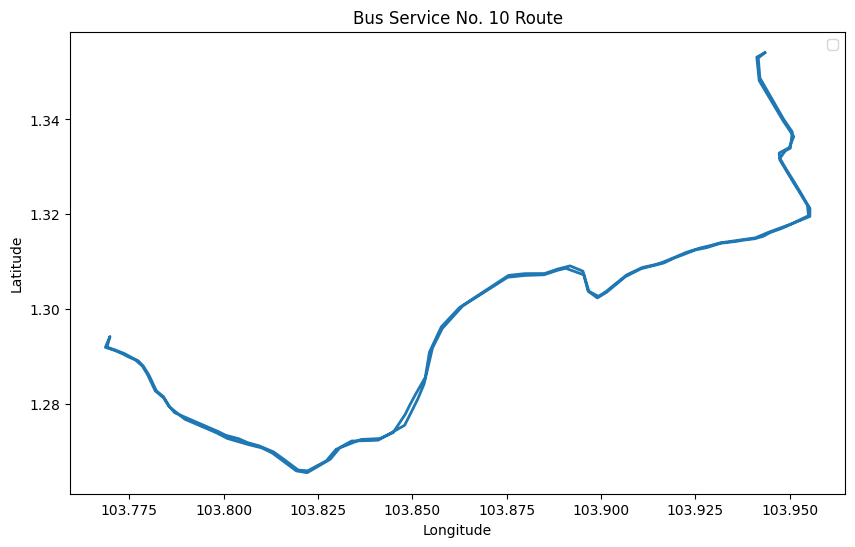

In [6]:
# Filter for bus service number 10
service_10_routes = bus_routes_lines_gdf[bus_routes_lines_gdf['ServiceNo'] == "10"]
print(service_10_routes['geometry'].head())

# Plot the route
fig, ax = plt.subplots(figsize=(10, 6))

# Plot each direction of service 10 with explicit label handling
for _, row in service_10_routes.iterrows():
    line = row['geometry']  # LineString geometry
    x, y = line.xy  # Get the x and y coordinates from the LineString

    # Plot the line and add a label for each unique direction
    ax.plot(x, y, linewidth=2)

# Remove duplicate labels in legend
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys())

# Add labels and title
ax.set_title("Bus Service No. 10 Route")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

plt.show()

## Train Lines

In [15]:
def duplicate_and_modify_station_code(df, original_code, new_codes):
    """
    Duplicates a row based on the original station code and replaces it 
    with multiple new station codes.
    
    Parameters:
    df (pd.DataFrame): The original dataframe.
    original_code (str): The Station_Code to find and duplicate.
    new_codes (list of str): The list of new Station_Codes to replace the original with.
    
    Returns:
    pd.DataFrame: Updated dataframe with the original code replaced by new codes.
    """
    # Select the row with the specified original code
    original_row = df[df['Station_Code'] == original_code]
    
    # Create modified copies of the row for each new code
    new_rows = []
    for code in new_codes:
        new_row = original_row.copy()
        new_row['Station_Code'] = code
        new_rows.append(new_row)
    
    # Remove the original row and add the modified copies
    df = df[df['Station_Code'] != original_code]
    df = pd.concat([df] + new_rows, ignore_index=True)
    
    return df

In [16]:
# Step 1: Union the geometries for the same station
unioned_gdf = geospatial_train_gdf.dissolve(by='STN_NAM_DE',aggfunc='first')

# Step 2: Calculate the centroid of the unioned polygon
unioned_gdf['centroid'] = unioned_gdf.centroid

# Optional Step: Replace geometry with centroid point
unioned_gdf['geometry'] = unioned_gdf['centroid']

# Reset index to clean up
unioned_gdf.reset_index(inplace=True)

# Function to normalize station names in train_stations_df
def normalize_station_name(name):
    return name.strip().upper()  # Ensure names are uppercase for consistent merging

# Apply normalization function to train_stations_df
train_stations['Normalized_Station'] = train_stations['MRT_Station'].apply(normalize_station_name)

# Create a column to append " MRT STATION" or " LRT STATION" based on the MRT_Line
train_stations['Station_MRT_LRT'] = train_stations.apply(
    lambda row: f"{row['Normalized_Station']} MRT STATION" if "LRT" not in row['MRT_Line'] else f"{row['Normalized_Station']} LRT STATION",
    axis=1
)

# Apply normalization to geospatial_train_df
# Strip ' MRT STATION' and ' LRT STATION' and normalize to uppercase
unioned_gdf['Normalized_Station'] = unioned_gdf['STN_NAM_DE'].str.strip().str.upper()

# Perform the merge on 'Station_MRT_LRT' from train_stations and 'Normalized_Station' from unioned_gdf
merged_train_stations = train_stations.merge(
    unioned_gdf,
    how='left',
    left_on='Station_MRT_LRT',
    right_on='Normalized_Station'
)

merged_train_stations = merged_train_stations[['Station_Code', 'MRT_Station', 'MRT_Line', 'TYP_CD_DES', 'geometry']]

#  Convert Pandas DataFrame to a GeoDataFrame
gdf = gpd.GeoDataFrame(merged_train_stations, geometry='geometry')

#  Reproject the GeoDataFrame to EPSG:4326 (WGS 84 - latitude/longitude)
gdf_4326 = gdf.to_crs(epsg=4326)

# Extract Longitude and Latitude from the reprojected geometries
gdf_4326['Longitude'] = gdf_4326.geometry.x
gdf_4326['Latitude'] = gdf_4326.geometry.y

#  Convert back to a Pandas DataFrame (if you don't need the geometry anymore)
geospatial_train_station = pd.DataFrame(gdf_4326)

geospatial_train_station = geospatial_train_station[['Station_Code', 'MRT_Station', 'MRT_Line', 'Longitude', 'Latitude']]

# Duplicate the row with 'PTC' and replace it with 'PW0', PW8', 'PE0', 'PE8'
geospatial_train_station = duplicate_and_modify_station_code(geospatial_train_station, 'PTC', ['PW0', 'PW8', 'PE0', 'PE8'])
# Duplicate the row with 'STC' and replace it with 'SW0', 'SW9', 'SE0', 'SE6'
geospatial_train_station = duplicate_and_modify_station_code(geospatial_train_station, 'STC', ['SW0', 'SW9', 'SE0', 'SE6'])
# Duplicate the row with 'BP6' and replace it with 'BP6', 'BP14'
geospatial_train_station = duplicate_and_modify_station_code(geospatial_train_station, 'BP6', ['BP6', 'BP14'])

geospatial_train_station['Train_Line'] = geospatial_train_station['Station_Code'].str.extract(r'([A-Za-z]+)')
geospatial_train_station['Station_No'] = geospatial_train_station['Station_Code'].str.extract(r'(\d+)').fillna(1).astype(int)

geospatial_train_station.head()

,Station_Code,MRT_Station,MRT_Line,Longitude,Latitude,Train_Line,Station_No
0,NS1,Jurong East,North-South Line,103.742263,1.333209,NS,1
1,NS2,Bukit Batok,North-South Line,103.749541,1.348997,NS,2
2,NS3,Bukit Gombak,North-South Line,103.751910,1.358672,NS,3
3,NS4,Choa Chu Kang,North-South Line,103.744369,1.385172,NS,4
4,NS5,Yew Tee,North-South Line,103.747402,1.397550,NS,5


In [17]:
# Convert to GeoDataFrame
train_stations_gdf = gpd.GeoDataFrame(
    geospatial_train_station,
    geometry=gpd.points_from_xy(geospatial_train_station.Longitude, geospatial_train_station.Latitude),
    crs="EPSG:4326"
)

# Step 2: Sort and group by train line to form continuous line segments for each line
train_stations_gdf = train_stations_gdf.sort_values(by=['Train_Line', 'Station_No'])

# Group by each train line to create LineString for each line
train_lines_gdf = train_stations_gdf.groupby('Train_Line').apply(
    lambda group: LineString(group.geometry.tolist()) if len(group) > 1 else None
).reset_index(name='geometry')

# Filter out rows where geometry is None (i.e., groups with less than 2 geometries)
train_lines_gdf = train_lines_gdf[train_lines_gdf['geometry'].notna()]

# Convert the result into a GeoDataFrame, which represents each train line as a LineString
train_lines_gdf = gpd.GeoDataFrame(train_lines_gdf, geometry='geometry', crs="EPSG:4326")

# Display the first few rows to confirm
print(train_lines_gdf.head())

  Train_Line                                           geometry
0         BP  LINESTRING (103.74455 1.38482, 103.74529 1.380...
1         CC  LINESTRING (103.84572 1.29938, 103.85066 1.296...
2         CE   LINESTRING (103.85908 1.28187, 103.85498 1.2757)
3         CG  LINESTRING (103.96205 1.33497, 103.98837 1.35731)
4         DT  LINESTRING (103.76157 1.37916, 103.7647 1.3693...


C:\Users\aiko\AppData\Local\Temp\ipykernel_32532\3452923685.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_lines_gdf = train_stations_gdf.groupby('Train_Line').apply(


In [ ]:
# Assuming you have train_lines_gdf with unique Train_Line values
unique_lines = train_lines_gdf['Train_Line'].unique()

# Create a colormap
colors = plt.cm.get_cmap('tab10', len(unique_lines))  # Using 'tab10' colormap for distinct colors

# Plot the bus routes (lines) and train stations (points)
fig, ax = plt.subplots(figsize=(10, 10))

# Plot each train line with a unique color
for i, line in enumerate(unique_lines):
    line_data = train_lines_gdf[train_lines_gdf['Train_Line'] == line]
    line_data.plot(ax=ax, color=colors(i), linewidth=2, label=line)

plt.legend()
plt.title("Train Stations and Routes")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.show()

## Overlapping with MRT Stations (Regardless of Line)
- Overlap train stations could be of different lines

In [18]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point, LineString
from shapely.ops import unary_union

# Function to sample unique points along each LineString
def sample_unique_points_along_line(line, distance=100):
    num_points = int(line.length // distance)
    points = [line.interpolate(i * distance) for i in range(num_points + 1)]
    return list(dict.fromkeys(points))  # Deduplicate points

# Sample points for each bus route, ensuring deduplication
def generate_unique_bus_route_points(bus_routes_gdf, distance=100):
    points_list = []
    for idx, row in bus_routes_gdf.iterrows():
        points = sample_unique_points_along_line(row['geometry'], distance)
        points_list.extend([(row['ServiceNo'], pt) for pt in points])
    return gpd.GeoDataFrame(points_list, columns=['ServiceNo', 'geometry'], geometry='geometry', crs="EPSG:3857")

# Load and reproject GeoDataFrames for bus routes and train lines
bus_routes_gdf = bus_routes_lines_gdf.to_crs("EPSG:3857")
train_routes_gdf = train_lines_gdf.to_crs("EPSG:3857")

# Generate unique points along each LineString for bus routes and train lines
bus_route_points = generate_unique_bus_route_points(bus_routes_gdf)
train_line_points = train_routes_gdf

# Buffer train line points for proximity search
buffer_distance = 200
train_line_buffers = train_line_points.copy()
train_line_buffers['geometry'] = train_line_buffers.geometry.buffer(buffer_distance)

# Perform spatial join to find bus points within the train line buffers
overlapping_points = gpd.sjoin(bus_route_points, train_line_buffers, how="inner", predicate='intersects')

# Calculate unique stop count, overlap count, and collect coordinates of overlapping stops
overlap_results = []
for service_no, group in bus_route_points.groupby('ServiceNo'):
    unique_total_stops = group.geometry.nunique()  # Count unique stops for this route
    
    # Get overlapping points for this specific bus service
    overlap_group = overlapping_points[overlapping_points['ServiceNo'] == service_no]
    unique_overlap_count = overlap_group.geometry.nunique()  # Count unique overlaps
    
    # Extract coordinates of overlapping stops and Reproject overlapping points to EPSG:4326 and extract coordinates
    overlap_group = overlap_group.to_crs("EPSG:4326")
    overlapping_coords = [pt.coords[0] for pt in overlap_group.geometry.unique()] if unique_overlap_count > 0 else []
    
    overlap_percentage = (unique_overlap_count / unique_total_stops) * 100 if unique_total_stops > 0 else 0

    overlap_results.append({
        'ServiceNo': service_no,
        'OverlapCount': unique_overlap_count,
        'TotalStops': unique_total_stops,
        'OverlapPercentage': overlap_percentage,
        'OverlappingStopCoordinates': overlapping_coords  # Add coordinates of overlapping stops
    })

# Convert results to DataFrame
overlap_results_df = pd.DataFrame(overlap_results)
print(overlap_results_df.head())


  ServiceNo  OverlapCount  TotalStops  OverlapPercentage  \
0        10           248         590          42.033898   
1       100           238         432          55.092593   
2      100A            22          45          48.888889   
3       101            70         134          52.238806   
4       102            55         209          26.315789   

                          OverlappingStopCoordinates  
0  [(103.94339098473912, 1.35407552367477), (103....  
1  [(103.87168992264615, 1.3504661017696897), (10...  
2  [(103.87168992264615, 1.3504661017696897), (10...  
3  [(103.87168992264615, 1.3504661017696897), (10...  
4  [(103.89266808874676, 1.3706069539461398), (10...  


In [19]:
# Convert results to DataFrame
overlap_results_df = pd.DataFrame(overlap_results)

# Sort by OverlapPercentage in descending order
overlap_results_df = overlap_results_df.sort_values(by='OverlapPercentage', ascending=False)

print(overlap_results_df.head())

    ServiceNo  OverlapCount  TotalStops  OverlapPercentage  \
13       107M           197         228          86.403509   
254        67           535         621          86.151369   
75        146            37          43          86.046512   
198       36B           209         257          81.322957   
12        107           222         275          80.727273   

                            OverlappingStopCoordinates  
13   [(103.89266808874676, 1.3706069539461398), (10...  
254  [(103.74578895932125, 1.38586897797184), (103....  
75   [(103.88178158303498, 1.3417353691755098), (10...  
198  [(103.93298577824508, 1.3107301672206597), (10...  
12   [(103.89266808874676, 1.3706069539461398), (10...  


In [20]:
# Filter out rows where ServiceNo contains any alphabetic characters
overlap_results_df = overlap_results_df[overlap_results_df['ServiceNo'].str.isnumeric()]

# Sort by OverlapPercentage in descending order
overlap_results_df = overlap_results_df.sort_values(by='OverlapPercentage', ascending=False)

print(overlap_results_df.head(20))

    ServiceNo  OverlapCount  TotalStops  OverlapPercentage  \
254        67           535         621          86.151369   
75        146            37          43          86.046512   
12        107           222         275          80.727273   
379       976           124         154          80.519481   
207       400            70          87          80.459770   
335        91            37          47          78.723404   
18        111           158         212          74.528302   
89        158           156         216          72.222222   
286        83            76         109          69.724771   
248        63           232         334          69.461078   
281        80           283         423          66.903073   
54        133           209         315          66.349206   
219        48           287         435          65.977011   
168        23           178         279          63.799283   
73        145           244         387          63.049096   
284     

## Overlapping with MRT Stations (Regardless of Line)
- Counts number of unique lines overlapped

In [ ]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point, LineString
from shapely.ops import unary_union

# Function to sample unique points along each LineString
def sample_unique_points_along_line(line, distance=100):
    num_points = int(line.length // distance)
    points = [line.interpolate(i * distance) for i in range(num_points + 1)]
    return list(dict.fromkeys(points))  # Deduplicate points

# Sample points for each bus route, ensuring deduplication
def generate_unique_bus_route_points(bus_routes_gdf, distance=100):
    points_list = []
    for idx, row in bus_routes_gdf.iterrows():
        points = sample_unique_points_along_line(row['geometry'], distance)
        points_list.extend([(row['ServiceNo'], pt) for pt in points])
    return gpd.GeoDataFrame(points_list, columns=['ServiceNo', 'geometry'], geometry='geometry', crs="EPSG:3857")

# Load and reproject GeoDataFrames for bus routes and train lines
bus_routes_gdf = bus_routes_lines_gdf.to_crs("EPSG:3857")
train_routes_gdf = train_lines_gdf.to_crs("EPSG:3857")

# Generate unique points along each LineString for bus routes and train lines
bus_route_points = generate_unique_bus_route_points(bus_routes_gdf)
train_line_points = train_routes_gdf

# Buffer train line points for proximity search
buffer_distance = 200
train_line_buffers = train_line_points.copy()
train_line_buffers['geometry'] = train_line_buffers.geometry.buffer(buffer_distance)

# Perform spatial join to find bus points within the train line buffers
overlapping_points = gpd.sjoin(bus_route_points, train_line_buffers, how="inner", predicate='intersects')

# Calculate unique stop count, overlap count, and collect coordinates of overlapping stops
overlap_results = []
for service_no, group in bus_route_points.groupby('ServiceNo'):
    unique_total_stops = group.geometry.nunique()  # Count unique stops for this route

    # Get overlapping points for this specific bus service
    overlap_group = overlapping_points[overlapping_points['ServiceNo'] == service_no]
    unique_overlap_count = overlap_group.geometry.nunique()  # Count unique overlaps

    # Group by train line to get unique train line overlaps
    train_line_overlap_count = overlap_group['Train_Line'].nunique()  # Assuming 'train_line_id' is the column name for train lines

    # Extract coordinates of overlapping stops and Reproject overlapping points to EPSG:4326 and extract coordinates
    overlap_group = overlap_group.to_crs("EPSG:4326")
    overlapping_coords = [pt.coords[0] for pt in overlap_group.geometry.unique()] if unique_overlap_count > 0 else []

    overlap_percentage = (unique_overlap_count / unique_total_stops) * 100 if unique_total_stops > 0 else 0

    overlap_results.append({
        'ServiceNo': service_no,
        'OverlapCount': unique_overlap_count,
        'TrainLineOverlapCount': train_line_overlap_count,
        'TotalStops': unique_total_stops,
        'OverlapPercentage': overlap_percentage,
        'OverlappingStopCoordinates': overlapping_coords  # Add coordinates of overlapping stops
    })

# Convert results to DataFrame
overlap_results_df = pd.DataFrame(overlap_results)
print(overlap_results_df.head())

In [ ]:
# Convert results to DataFrame
overlap_results_df = pd.DataFrame(overlap_results)

# Sort by OverlapPercentage in descending order
overlap_results_df = overlap_results_df.sort_values(by='OverlapPercentage', ascending=False)

print(overlap_results_df.head(20))

In [ ]:
# Filter out rows where ServiceNo contains any alphabetic characters
overlap_results_df = overlap_results_df[overlap_results_df['ServiceNo'].str.isnumeric()]

# Sort by OverlapPercentage in descending order
overlap_results_df = overlap_results_df.sort_values(by='OverlapPercentage', ascending=False)

print(overlap_results_df.head(20))

## Overlapping with MRT Lines (Calculates overlap with each MRT Line)

In [ ]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point, LineString
from shapely.ops import unary_union

# Function to sample unique points along each LineString
def sample_unique_points_along_line(line, distance=100):
    num_points = int(line.length // distance)
    points = [line.interpolate(i * distance) for i in range(num_points + 1)]
    return list(dict.fromkeys(points))  # Deduplicate points

# Sample points for each bus route, ensuring deduplication
def generate_unique_bus_route_points(bus_routes_gdf, distance=100):
    points_list = []
    for idx, row in bus_routes_gdf.iterrows():
        points = sample_unique_points_along_line(row['geometry'], distance)
        points_list.extend([(row['ServiceNo'], pt) for pt in points])
    return gpd.GeoDataFrame(points_list, columns=['ServiceNo', 'geometry'], geometry='geometry', crs="EPSG:3857")

# Load and reproject GeoDataFrames for bus routes and train lines
bus_routes_gdf = bus_routes_lines_gdf.to_crs("EPSG:3857")
train_routes_gdf = train_lines_gdf.to_crs("EPSG:3857")

# Generate unique points along each LineString for bus routes and train lines
bus_route_points = generate_unique_bus_route_points(bus_routes_gdf)
train_line_points = train_routes_gdf

# Buffer train line points for proximity search
buffer_distance = 200
train_line_buffers = train_line_points.copy()
train_line_buffers['geometry'] = train_line_buffers.geometry.buffer(buffer_distance)

# Perform spatial join to find bus points within the train line buffers
overlapping_points = gpd.sjoin(bus_route_points, train_line_buffers, how="inner", predicate='intersects')

# Calculate unique stop count and overlap percentages
overlap_results = []

# Group by both ServiceNo and train_line_id
for (service_no, train_line_id), group in overlapping_points.groupby(['ServiceNo', 'Train_Line']):
    unique_total_stops = bus_route_points[bus_route_points['ServiceNo'] == service_no].geometry.nunique()  # Count unique stops for this route
    unique_overlap_count = group.geometry.nunique()  # Count unique overlaps for this train line

    overlap_percentage = (unique_overlap_count / unique_total_stops) * 100 if unique_total_stops > 0 else 0

    # Extract coordinates of overlapping stops and Reproject overlapping points to EPSG:4326 and extract coordinates
    group = group.to_crs("EPSG:4326")
    overlapping_coords = [pt.coords[0] for pt in group.geometry.unique()] if unique_overlap_count > 0 else []

    overlap_results.append({
        'ServiceNo': service_no,
        'TrainLineID': train_line_id,  # Assuming 'train_line_id' is the identifier for train lines
        'OverlapCount': unique_overlap_count,
        'TotalStops': unique_total_stops,
        'OverlapPercentage': overlap_percentage,
        'OverlappingStopCoordinates': overlapping_coords  # Add coordinates of overlapping stops
    })

# Convert results to DataFrame
overlap_results_df = pd.DataFrame(overlap_results)
print(overlap_results_df.head())

In [ ]:
# Convert results to DataFrame
overlap_results_df = pd.DataFrame(overlap_results)

# Sort by OverlapPercentage in descending order
overlap_results_df = overlap_results_df.sort_values(by='OverlapPercentage', ascending=False)

print(overlap_results_df.head(25))

In [ ]:
# Filter out rows where ServiceNo contains any alphabetic characters
overlap_results_df = overlap_results_df[overlap_results_df['ServiceNo'].str.isnumeric()]

# Sort by OverlapPercentage in descending order
overlap_results_df = overlap_results_df.sort_values(by='OverlapPercentage', ascending=False)

print(overlap_results_df.head(20))

In [ ]:
# Filter out rows where TrainLine is Thomson-East Coast Line
overlap_results_df = overlap_results_df[overlap_results_df['TrainLineID'] == "TE"]

# Sort by OverlapPercentage in descending order
overlap_results_df = overlap_results_df.sort_values(by='OverlapPercentage', ascending=False)

print(overlap_results_df.head(10))

## Visualisation of Overlap

In [ ]:
# Example plot ServiceNo '976' and Train_Line 'BP'
service_976_routes = bus_routes_lines_gdf[bus_routes_lines_gdf['ServiceNo'] == "976"]
bp_train_line = train_lines_gdf[train_lines_gdf['Train_Line'] == "BP"]

# Plot the routes
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the train line for Train_Line 'BP'
for _, row in bp_train_line.iterrows():
    line = row['geometry']
    x, y = line.xy
    ax.plot(x, y, color='green', linewidth=2, label='Train Line BP')

# Plot the bus route for ServiceNo '976'
for _, row in service_976_routes.iterrows():
    line = row['geometry']
    x, y = line.xy
    ax.plot(x, y, color='purple', linewidth=2, label='Bus Service No. 976')

# Set the limits for x and y axes
ax.set_xlim([103.7, 103.8])  # Adjust these limits to focus on the area of interest
ax.set_ylim([1.37, 1.39])      # Adjust these limits to focus on the area of interest

# Remove duplicate labels in the legend
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys())

# Add labels and title
ax.set_title("Merged Routes of Bus Service No. 976 and Train Line BP")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.grid(True)

plt.show()

In [ ]:
# Example plot ServiceNo '976' and Train_Line 'BP'
service_91_routes = bus_routes_lines_gdf[bus_routes_lines_gdf['ServiceNo'] == "91"]
cc_train_line = train_lines_gdf[train_lines_gdf['Train_Line'] == "CC"]

# Plot the routes
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the train line for Train_Line 'BP'
for _, row in cc_train_line.iterrows():
    line = row['geometry']
    x, y = line.xy
    ax.plot(x, y, color='yellow', linewidth=2, label='Train Line CC')

# Plot the bus route for ServiceNo '976'
for _, row in service_91_routes.iterrows():
    line = row['geometry']
    x, y = line.xy
    ax.plot(x, y, color='purple', linewidth=2, label='Bus Service No. 91')

# Set the limits for x and y axes
ax.set_xlim([103.75, 104.0])  # Adjust these limits to focus on the area of interest
ax.set_ylim([1.2, 1.40])      # Adjust these limits to focus on the area of interest

# Remove duplicate labels in the legend
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys())

# Add labels and title
ax.set_title("Merged Routes of Bus Service No. 91 and Train Line CC")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.grid(True)

plt.show()

In [ ]:
# Example plot ServiceNo '36B' and Train_Line 'TE'
service_36b_routes = bus_routes_lines_gdf[bus_routes_lines_gdf['ServiceNo'] == "36B"]
te_train_line = train_lines_gdf[train_lines_gdf['Train_Line'] == "TE"]

# Plot the routes
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the train line for Train_Line 'BP'
for _, row in te_train_line.iterrows():
    line = row['geometry']
    x, y = line.xy
    ax.plot(x, y, color='brown', linewidth=2, label='Train Line TE')

# Plot the bus route for ServiceNo '976'
for _, row in service_36b_routes.iterrows():
    line = row['geometry']
    x, y = line.xy
    ax.plot(x, y, color='purple', linewidth=2, label='Bus Service No. 36B')

# Set the limits for x and y axes
ax.set_xlim([103.75, 103.95])  # Adjust these limits to focus on the area of interest
ax.set_ylim([1.20, 1.50])      # Adjust these limits to focus on the area of interest

# Remove duplicate labels in the legend
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys())

# Add labels and title
ax.set_title("Merged Routes of Bus Service No. 36B and Train Line TE")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.grid(True)

plt.show()